In [1]:
from climada.hazard import Hazard

In [2]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import os




#Dictionary with years for warming levels
years_warming_level = {
    '1': {
        'rcp26': {'gfdl-esm2m': [2006, 2023], 'miroc5': [2006, 2025], 'hadgem2-es': [2006, 2019], 'ipsl-cm5a-lr': None},
        'rcp60': {'gfdl-esm2m': [2006, 2027], 'miroc5': [2013, 2034], 'hadgem2-es': [2006, 2023], 'ipsl-cm5a-lr': None}
    },
    '2': {
        'rcp26': {'gfdl-esm2m': None, 'miroc5': None, 'hadgem2-es': None, 'ipsl-cm5a-lr': [2019, 2040]},
        'rcp60': {'gfdl-esm2m': [2066, 2087], 'miroc5': [2061, 2082], 'hadgem2-es': [2040, 2061], 'ipsl-cm5a-lr': [2019, 2040]}
    }
}


In [3]:

# #Dictionary with years for warming levels
# years_warming_level = {
#     '1': {
#         'rcp26': {'gfdl-esm2m': [2006, 2023]},
#     },
    
# }

# Function definitions for load_temperature_data, calculate_percentile, identify_heatwaves remain the same
from scipy.stats import norm

import xarray as xr
import os

def load_vietnam_data(file_path, variable):
    """
    Load temperature data from a netCDF4 file, subset for Vietnam.
    """
    # Define the bounding box for Vietnam
    lat_bounds = slice(25, 8)  # Vietnam's approximate latitude bounds
    lon_bounds = slice(100, 110)  # Vietnam's approximate longitude bounds
    
    # Load the data and select the region of interest
    data = xr.open_dataset(file_path)[variable]  # Assuming 'tas' is the temperature variable
    data = data.sel(lat=lat_bounds, lon=lon_bounds)
    
    return data




In [4]:
def round_year(year):
    if year < 2010:
        return 2006
    elif year % 10 == 0 and year > 2010:
        return (year - 10)+1
    else:
        return (year // 10) * 10 +1

def get_relevant_files(years_range, scenario, model, base_path, variable):
    start_year, end_year = years_range
    start_year_rounded = round_year(start_year)
    end_year_rounded = round_year(end_year)
    middle_year_rounded = round_year(start_year+9)
    middle_year2_rounded = round_year(start_year+11)

    unique_files_starting_year=np.unique([start_year_rounded,end_year_rounded,middle_year_rounded, middle_year2_rounded])
    files = []
    for year in unique_files_starting_year:  # Adjust step based on your file coverage
        if year == 2006:
            end_year_file = 2010
        else:
            end_year_file = year+9
        file_base = f"{base_path}/{variable}_day_{model}_{scenario}_r1i1p1_EWEMBI_{str(year)}0101-{end_year_file}1231"
        file_path = f"{file_base}.nc4"
        if os.path.exists(file_path):
            files.append(file_path)
       
    return files

In [5]:
# Initialize a dictionary to store heatwave data
heatwave_data_dict = {}
base_path = "/nfs/n2o/wcr/szelie/isimip2b"
# Process data for each warming level
heat_hazards ={}
from climada.hazard import Centroids
import pandas as pd
import scipy as sp
import datetime
from climada.hazard import Hazard
def calculate_wbgt(Ta, RH, SR):
    # ESI formula for WBGT
    ESI = (0.63 * Ta - 0.03 * RH + 0.002 * SR +
           0.0054 * (Ta * RH) - 0.073 * (0.1 + SR) ** -1)
    ESI[ESI < 20] = 0
    return ESI

for warming_level in ['1','2']:
    heat_hazards[warming_level] = []
    heatwave_data_dict[warming_level] = {}

    for scenario in years_warming_level[warming_level]:
        
        heatwave_data_dict[warming_level][scenario] = {}
        
        for model, years in years_warming_level[warming_level][scenario].items():
            if model == 'hadgem2-es':
                model_upper='HadGEM2-ES'
            else:
                model_upper=model.upper()
            if years is None:
                continue
            hurs_files = get_relevant_files(years, scenario, model_upper, base_path, 'hurs')
            tas_files = get_relevant_files(years, scenario, model_upper, base_path, 'tas')
            rsds_files = get_relevant_files(years, scenario, model_upper, base_path, 'rsds')

            hurs_data_list = []
            tas_data_list = []
            rsds_data_list = []
            for hurs_file, tas_file, rsds_file in zip(hurs_files, tas_files, rsds_files):
                hurs_data = load_vietnam_data(os.path.join(base_path, hurs_file),'hurs')
                tas_data = load_vietnam_data(os.path.join(base_path, tas_file),'tas')
                rsds_data = load_vietnam_data(os.path.join(base_path, rsds_file), 'rsds')

                hurs_data_list.append(hurs_data)
                tas_data_list.append(tas_data)
                rsds_data_list.append(rsds_data)
            
            #print(years)
            tas_data = xr.concat(tas_data_list, dim='time')
            tas_data_relevant_years = tas_data.sel(time=slice("-".join([str(years[0]),"01","01"]), "-".join([str(years[1]-1),"12","31"])))

            hurs_data = xr.concat(hurs_data_list, dim='time')
            hurs_data_relevant_years = hurs_data.sel(time=slice("-".join([str(years[0]),"01","01"]), "-".join([str(years[1]-1),"12","31"])))

            rsds_data = xr.concat(rsds_data_list, dim='time')
            rsds_data_relevant_years = rsds_data.sel(time=slice("-".join([str(years[0]),"01","01"]), "-".join([str(years[1]-1),"12","31"])))


            Ta = tas_data_relevant_years.values - 273.15  # Convert to Celsius
            RH = hurs_data_relevant_years.values  # It is assumed that it's already in percentage
            SR = rsds_data_relevant_years.values

            wbgt = calculate_wbgt(Ta, RH, SR)

            n_times, n_latitude, n_longitude = wbgt.shape
            wbgt_reshaped = wbgt.reshape(n_times, n_latitude * n_longitude)
            #wbgt_reshaped[wbgt_reshaped<25] = 0
            wbgt_reshaped = sp.sparse.csr_matrix(wbgt_reshaped)
            df = hurs_data.to_dataframe().groupby(['lat','lon']).sum().reset_index()
            centroids = Centroids.from_lat_lon(df.lat,df.lon)

            time = tas_data_relevant_years.time
            ordinal_dates = pd.to_datetime(time.values).to_pydatetime()
            ordinal_dates = [date.toordinal() for date in ordinal_dates]
            years = [datetime.date.fromordinal(date).year for date in ordinal_dates]
            event_name = ["_".join([str(year), model, scenario]) for year in years]
            #print(event_name)
            wbgt_haz = Hazard(
                haz_type="HW",
                centroids=centroids,
                frequency=np.ones(len(time)) / len(np.unique(years)),
                event_id=np.arange(1, len(time) + 1),
                event_name=event_name,
                date=ordinal_dates,
                intensity=wbgt_reshaped
            )
            wbgt_haz.intensity.data[wbgt_haz.intensity.data<25] = 0
            heat_hazards[warming_level].intensity.eliminate_zeros()
            #wbgt_haz.intensity.data[wbgt_haz.centroids.region_id[wbgt_haz.intensity.nonzero()[1]] != 1] = 0

            heat_hazards[warming_level].append(wbgt_haz)
    heat_hazards[warming_level] = Hazard.concat(heat_hazards[warming_level])

In [12]:
for warming_level in ['1','2']:
    heat_hazards[warming_level].intensity.eliminate_zeros()

In [10]:
len(np.unique(heat_hazards['2'].event_name))

105

(array([2.640849e+06, 3.997047e+06, 4.703194e+06, 3.504295e+06,
        1.377752e+06, 3.501240e+05, 7.280200e+04, 1.266100e+04,
        1.024000e+03, 8.500000e+01]),
 array([25.      , 26.212835, 27.42567 , 28.638506, 29.851341, 31.064177,
        32.27701 , 33.489845, 34.702682, 35.91552 , 37.128353],
       dtype=float32),
 <BarContainer object of 10 artists>)

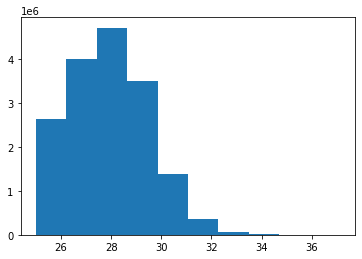

In [13]:
import matplotlib.pyplot as plt
plt.hist(heat_hazards["1"].intensity.data)

(array([2.154252e+06, 3.052377e+06, 4.649435e+06, 4.342878e+06,
        2.422332e+06, 7.031390e+05, 1.475830e+05, 2.349700e+04,
        2.279000e+03, 7.600000e+01]),
 array([25.      , 26.251764, 27.503529, 28.755295, 30.00706 , 31.258823,
        32.51059 , 33.762352, 35.01412 , 36.26588 , 37.517647],
       dtype=float32),
 <BarContainer object of 10 artists>)

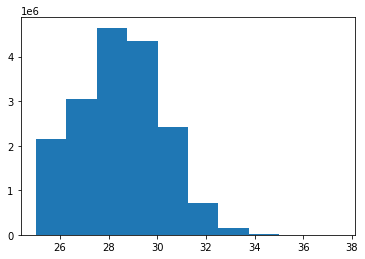

In [14]:
import matplotlib.pyplot as plt
plt.hist(heat_hazards["2"].intensity.data)

In [7]:
base_path / "/tas_day_HadGEM2-ES_rcp60_r1i1p1_EWEMBI_20510101-20601231.nc4"

PosixPath('/tas_day_HadGEM2-ES_rcp60_r1i1p1_EWEMBI_20510101-20601231.nc4')

In [82]:
from pathlib import Path
import xarray as xr

base_path = Path("/nfs/n2o/wcr/szelie/isimip2b")

path = base_path / "rsds_day_HadGEM2-ES_rcp60_r1i1p1_EWEMBI_20510101-20601231.nc4"

In [36]:
had = load_vietnam_data(path, 'rsds')

path2 = base_path / "rsds_day_MIROC5_rcp60_r1i1p1_EWEMBI_20510101-20601231.nc4"
mir = load_vietnam_data(path2, 'rsds')


In [26]:
mir.values.flatten()

array([283.41788, 283.7245 , 283.37772, ..., 298.8913 , 298.5747 ,
       298.63535], dtype=float32)

(array([ 26484.,  75495., 150261., 290568., 409656., 503758., 510075.,
        344818., 146305.,  26620.]),
 array([2.8001067e-01, 3.5314823e+01, 7.0349640e+01, 1.0538445e+02,
        1.4041927e+02, 1.7545407e+02, 2.1048889e+02, 2.4552370e+02,
        2.8055850e+02, 3.1559332e+02, 3.5062814e+02], dtype=float32),
 <BarContainer object of 10 artists>)

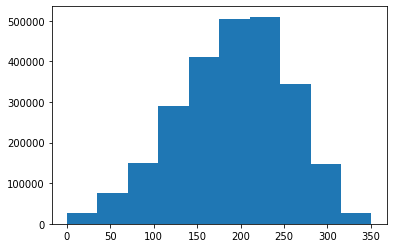

In [37]:
import matplotlib.pyplot as plt
plt.hist(mir.values.flatten())

(array([ 27579., 102315., 158784., 215787., 330819., 530010., 597882.,
        391793., 125921.,   3150.]),
 array([  0.5217427,  36.808666 ,  73.09559  , 109.38251  , 145.66943  ,
        181.95634  , 218.24327  , 254.5302   , 290.8171   , 327.10403  ,
        363.39096  ], dtype=float32),
 <BarContainer object of 10 artists>)

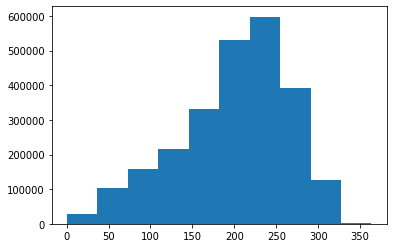

In [38]:
plt.hist(had.values.flatten())

In [15]:
from climada.util.api_client import Client
client = Client()
pop = client.get_litpop(exponents=(0, 1), country="VNM")

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


In [25]:
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet

impf_set = ImpactFuncSet()

impf_hw = ImpactFunc()
impf_hw.id = 1
impf_hw.haz_type = 'HW'
impf_hw.name = 'Step function heatwave'
impf_hw.intensity_unit = ''
impf_hw.intensity = np.array([0, 0, 32.9, 33, 50])
impf_hw.mdd = np.array([0, 0, 0, 1, 1])
impf_hw.paa = np.ones(impf_hw.intensity.shape)
impf_hw.check() 
impf_set.append(impf_hw)


In [19]:
def aggregate_impact_from_event_name(impact, how='sum', exp=None):
    """
    Aggregate the impact per year to make yearsets. Maximum impact per year
    at each exposure point is exposure value if exp is not None.

    Parameters
    ----------
    impact : Impact
        Impact with an impact matrix and events with dates per year
    how : How to aggregate impacts, options are 'sum' or 'max'
    exp : Exposure
        Exposure of Impact to cap the impact value at the value of the exposure
    Raises
    ------
    AttributeError
        If impact matrix is empty.

    Returns
    -------
    impact : Impact
        Impact yearset.

    """

    imp = copy.deepcopy(impact)
    if how == 'sum':
        mask = [np.ma.make_mask(np.array(imp.event_name) == event).astype(int)
                for event in np.unique(imp.event_name)]
        mask_matrix = sp.sparse.csr_matrix(mask)
        imp_mat = mask_matrix.dot(imp.imp_mat)

    elif how == 'max':
        imp_mat = sp.sparse.csr_matrix(sp.sparse.vstack(
        [imp.imp_mat[(np.array(imp.event_name) == event).astype(bool)].max(axis=0)
         for event in np.unique(imp.event_name)]))

    frequency = np.ones(imp_mat.shape[0])/imp_mat.shape[0]
    date = np.arange(1, len(frequency) + 1)
    event_id = np.arange(1, len(frequency) + 1)
    event_name = np.unique(imp.event_name)
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, frequency)
    
    impact_aggr = Impact(
        event_id=event_id,
        event_name=event_name,
        date=date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=impact.coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=frequency,
        tot_value=imp.tot_value,
        unit=imp.unit,
        frequency_unit="1/year"
    )
    return impact_aggr


In [71]:
aggregate_impact_from_event_name(impacts[warming_level], how="max")

2023-11-23 17:23:36,263 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


In [26]:
from climada.engine import Impact, ImpactCalc
from climada.util.constants import DEF_CRS
import copy
from pathlib import Path
path_impacts = Path("/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/impacts/global/")
impacts = {}
for warming_level in ['1', '2']:
    impacts[warming_level] = ImpactCalc(pop, impf_set, heat_hazards[warming_level]).impact(save_mat=True)
    impacts[warming_level] = aggregate_impact_from_event_name(impacts[warming_level], how="max")
    # # # impacts[warming_level] = aggregate_impact_by_date(impacts[warming_level], how="max")
    impacts[warming_level].write_csv(path_impacts / f"csvs_climada_v4/HW_impact_pop_150arcsec_{warming_level}_vnm.csv")
    impacts[warming_level].write_sparse_csr(path_impacts / f"npz/HW_impact_pop_150arcsec_{warming_level}_vnm.npz")

2023-11-24 10:33:02,304 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-11-24 10:33:09,830 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


In [23]:
impacts[warming_level].at_event

array([       0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,   955431.66445117,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,  8290983.78764332,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
          91164.5751641 ,   639747.72912445,        0.        ,
        2878472.87023142,   814211.7068045 ,        0.        ,
         341384.01222527, 10033336.47423

<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (people)'>

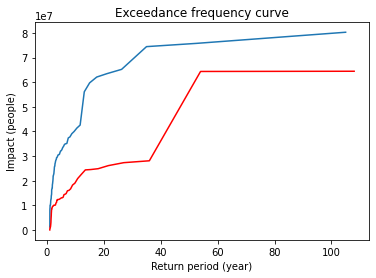

In [27]:
fig,ax = plt.subplots()
impacts['2'].calc_freq_curve().plot(axis=ax)
impacts['1'].calc_freq_curve().plot(axis=ax, color="red")


In [11]:
from climada.engine import Impact, ImpactCalc


In [159]:
# from climada.engine import Impact
# from pathlib import Path
# path_impacts = Path("/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/impacts/global/")

# impacts = {}
# for warming_level in ['1', '2']:
#     impacts[warming_level] = Impact.from_csv(path_impacts / f"csvs_climada_v4/HW_impact_pop_150arcsec_{warming_level}_global.csv")
#     impacts[warming_level].imp_mat = Impact.read_sparse_csr(path_impacts / f"npz/HW_impact_pop_150arcsec_{warming_level}_global.npz")

In [125]:
import itertools
import numpy as np
import pycountry
import copy
from climada.util.constants import DEF_CRS
from climada.engine import Impact, ImpactCalc

from climada.util import coordinates
from climada.engine import Impact

def impact_select_country(impact, country):
    """
    Create a new impact object containing only the data for a specified country.

    This function filters an existing impact object to include only the data points
    that are within the boundaries of a given country. The function uses latitude and 
    longitude coordinates from the 'impact' object to determine the country of each 
    data point. It then filters the impact matrix and coordinates to include only those
    corresponding to the specified country.

    The country is specified by its ISO 3166-1 numeric code as a three-digit string. 
    For example, '840' for the United States, '124' for Canada, and '392' for Japan.

    Parameters:
    ----------
    impact : Impact
        The impact object to be filtered. This object should contain latitude and 
        longitude coordinates ('coord_exp') and an impact matrix ('imp_mat').

    country : str
        The three-digit string representing the ISO 3166-1 numeric country code.

    Returns:
    -------
    Impact
        A new Impact object containing only the data for the specified country.
    """
    lat, lon = np.array(impact.coord_exp).T
    countries_num = coordinates.get_country_code(lat, lon)
    countries_num = np.array([format(num, '03d') for num in countries_num])
    imp_mat = impact.imp_mat[:, countries_num == str(country)]
    coord_exp = impact.coord_exp[countries_num == str(country)]
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, impact.frequency)
    
    impact_country = Impact(
        event_id=impact.event_id,
        event_name=impact.event_name,
        date=impact.date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=impact.frequency,
        unit=impact.unit,
        frequency_unit=impact.unit,
    )
    return impact_country

In [126]:
test = impact_select_country(impacts[warming_level], 704)

In [130]:
len(pop.gdf)

16092

In [129]:
test.coord_exp.shape

(16092, 2)

In [168]:
impacts[warming_level].at_event

array([1.01965523e+06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.91461461e+07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.96892887e+07, 2.30162500e+06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.44216027e+05, 4.97844268e+06, 0.00000000e+00,
       0.00000000e+00, 6.83007725e+06, 0.00000000e+00, 5.06558492e+06,
       5.95592380e+07, 3.15464028e+06, 5.58218316e+05, 4.78918617e+07,
       9.26720895e+07, 5.58218316e+05, 5.58218316e+05, 5.58218316e+05,
       5.58218316e+05, 4.95978792e+07, 2.81172471e+07, 5.58218316e+05,
       2.10977274e+07, 5.58218316e+05, 6.23170744e+05, 6.63114825e+06,
       6.33263643e+07, 5.58218316e+05, 5.58218316e+05, 4.04403793e+07,
       5.61389079e+06, 5.58218316e+05, 4.78246592e+07, 5.90509629e+05,
       3.11988542e+07, 4.37848145e+07, 1.16182364e+06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 8.62101284e+06, 6.72442224e+06,
       3.31224488e+06, 6.40795178e+05, 7.92705099e+06, 6.43158760e+06,
      

<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (people)'>

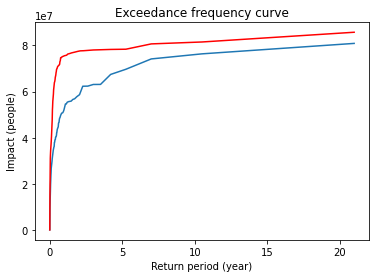

In [73]:
fig,ax = plt.subplots()
impacts["1"].calc_freq_curve().plot(axis=ax)
impacts["2"].calc_freq_curve().plot(axis=ax,color="red")

<AxesSubplot:title={'center':'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (people)'>

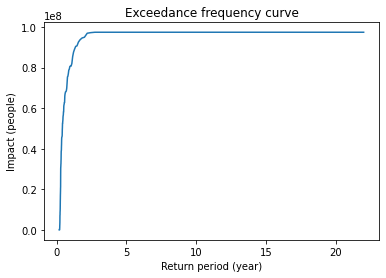

In [134]:
impacts["2"].calc_freq_curve().plot()